# Loading Libraries

In [108]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('ERROR') # only show error messages 

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k, 
    get_top_k_items,
    rmse,
    mae,
    rsquared,
    exp_var
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.utils.constants import SEED as DEFAULT_SEED

# System & OS
import sys
import os
import shutil
#import papermill as pm
import pandas as pd

# Turn of Warnings for Readability 
import warnings
warnings.filterwarnings("ignore")

# Import & Read Datasets

In [109]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_test.csv", index_col=0)

In [110]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (206861, 3)
Shape of Test: 	 (51879, 3)


In [111]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3690
Unique Users in Test: 3690
Unique Items in Train: 2746
Unique Items in Test: 2746


# Data Preparation

In [112]:
# Change name of columns 
train = train.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
test = test.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})

In [113]:
# Write Dataset to CSV files. This is a pre-step for the NCF Dataset preparation
train_file = "./or_train.csv"
test_file = "./or_test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [114]:
# Create the NCF Dataset 
data = NCFDataset(train_file=train_file, test_file=test_file, seed=1, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./or_train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./or_test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./or_test_full.csv ...
100%|██████████| 3690/3690 [00:40<00:00, 91.80it/s] 
INFO:recommenders.models.ncf.dataset:Indexing ./or_test_full.csv ...


# Baseline Model

In [26]:
# Initiate Model with pretrained NeuMF
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=50,
    batch_size=50,
    learning_rate=1e-3,
    verbose=10,
    seed=1
)

2023-06-19 13:45:25.024116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 13:45:25.035937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


In [27]:
# Fit the Modek 
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [20.38s]: train_loss = 0.370194 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [21.03s]: train_loss = 0.364789 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [20.67s]: train_loss = 0.361750 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [21.02s]: train_loss = 0.359382 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [21.20s]: train_loss = 0.358611 


Took 1061.36715395801 seconds for training.


In [28]:
# Predict all user and items pairings in Test 
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test.iterrows()]

# Create a Datafragme from the Predictions 
predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head()

,userID,itemID,prediction
0,1,1249,0.367157
1,1,396,0.077538
2,1,2601,0.327272
3,1,912,0.461480
4,1,1032,0.273281


In [45]:
predictions['prediction'] = predictions['prediction'].apply(lambda x: 1 if x > 0.5 else 0)

In [48]:
acc = accuracy_score(test.rating, predictions.prediction)
print(acc)

0.31667919582104515


In [29]:
# Predict ALL User & Item Pairings 
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 47.797705667006085 seconds for prediction.


In [30]:
# Evaluate Recall & Preicison at 10 
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=10)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=10)

print("Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Precision@K:	0.084282
Recall@K:	0.073742


# Hyperparameter Tuning 

In [ ]:
# Initiate Lists for Hyperparameters 
factors = [4, 16, 50]
layers = [[16, 8, 4], [32, 16, 8], [200, 100, 50]]

# Initiate Lists for Assessment
accuracy = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
num_factors = []
layer_shapes = []

for f in factors:
    for l in layers:
        ##### GMF MODEL ##### 
        # Initiate GMF Model
        gmf_model = NCF(
            n_users=data.n_users,
            n_items=data.n_items,
            model_type="GMF",
            n_factors=f,
            layer_sizes=l,
            n_epochs=50,
            batch_size=50,
            learning_rate=0.005,
            seed=1,
            verbose=False
        )
        
        # Fit GMF Model: 
        gmf_model.fit(data)
        
        # Save GMF Model:
        gmf_model.save(dir_name='.pretrain/GMF')
        
        ##### MLP MODEL ##### 
        # Initiate MLP Model                 
        mlp_model = NCF(
            n_users=data.n_users,
            n_items=data.n_items,
            model_type="MLP",
            n_factors=f,
            layer_sizes=l,
            n_epochs=50,
            batch_size=50,
            learning_rate=0.005,
            seed=1,
            verbose=False
        )
        
        # Fit MLP Model
        mlp_model.fit(data)
        
        # Save MLP Model
        mlp_model.save(dir_name='.pretrain/MLP')
        
        ##### NeuMF Layer #####
        # Initiate NeuMF Model
        model = NCF(
            n_users=data.n_users,
            n_items=data.n_items,
            model_type="NeuMF",
            n_factors=f,
            layer_sizes=l,
            n_epochs=50,
            batch_size=50,
            learning_rate=0.005,
            seed=1,
            verbose=False
        )
        
        # Load pretrained Models
        model.load(gmf_dir='.pretrain/GMF', mlp_dir='.pretrain/MLP', alpha=0.5)
        
        # Fit NeuMF Model
        model.fit(data)
        
        
        ##### ACCURACY PREDICTION #####
        # Predict all user and items pairings in Test 
        predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
                    for (_, row) in test.iterrows()]

        # Create a Datafragme from the Predictions 
        predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
        
        # Binarize Output
        predictions['prediction'] = predictions['prediction'].apply(lambda x: 1 if x > 0.5 else 0)
        
        # Predict Accuracy
        acc = accuracy_score(test.rating, predictions.prediction)
        
        # Add Accuracy to list
        accuracy.append(acc)
        
        ##### TOP K PREDICTION
        # Predict All Pairings  
        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        # Create Data Frame and Merge
        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})
        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
        
        # Recall & Precision at 10 
        eval_precision_10 = precision_at_k(test, all_predictions, col_prediction='prediction', k=10)
        eval_recall_10 = recall_at_k(test, all_predictions, col_prediction='prediction', k=10)
        
        # Recall & Precision at 20
        eval_precision_20 = precision_at_k(test, all_predictions, col_prediction='prediction', k=20)
        eval_recall_20 = recall_at_k(test, all_predictions, col_prediction='prediction', k=20)
        
        
        # Append Lists
        recall_10.append(eval_recall_10)
        recall_20.append(eval_recall_20)
        precision_10.append(eval_precision_10)
        precision_20.append(eval_precision_20)
        num_factors.append(f)
        layer_shapes.append(l)
        
        # Print intermediate Status for Recall@10
        print("Recall@10 for Num Factors: ", f, "Layer Shape: ", l, ":\t", eval_recall_10)
        
        # Print intermediate Status for Recall@20
        print("Recall@20 for Num Factors: ", f, "Layer Shape: ", l, ":\t", eval_recall_20)
        

In [ ]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning = pd.DataFrame({
    "layer size": layer_shapes,
    "factors": num_factors,
    "accuracy": accuracy,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning.sort_values(by='recall@10', ascending=False)

,layer size,factors,accuracy,recall@10,recall@20,precision@10,precision@20
4,"[32, 16, 8]",16,0.350816,0.056391,0.102389,0.058184,0.053130
5,"[200, 100, 50]",16,0.369706,0.049181,0.092467,0.051870,0.049228
7,"[32, 16, 8]",50,0.393435,0.045590,0.085187,0.044173,0.042818
6,"[16, 8, 4]",50,0.386746,0.045227,0.087878,0.043902,0.043753
8,"[200, 100, 50]",50,0.390987,0.044699,0.083756,0.043984,0.043008
3,"[16, 8, 4]",16,0.149155,0.041654,0.071153,0.046829,0.041247
2,"[200, 100, 50]",4,0.299871,0.037455,0.065578,0.046531,0.041125
0,"[16, 8, 4]",4,0.201122,0.032559,0.057619,0.038862,0.034106
1,"[32, 16, 8]",4,0.844928,0.004949,0.009060,0.004417,0.004255


In [ ]:
df_tuning.to_csv("or_binary_results.csv")

# Analysis of Hyperparameters

In [ ]:
# Impact of Factors
df_tuning.groupby("factors")['recall@10'].mean().sort_values(ascending=False)

factors
16    0.049076
50    0.045172
4     0.024988
Name: recall@10, dtype: float64

In [ ]:
# Impact of Layer Size
df_tuning['layer size'] = df_tuning['layer size'].astype(str)

df_tuning.groupby("layer size")['recall@10'].mean().sort_values(ascending=False)

layer size
[200, 100, 50]    0.043778
[16, 8, 4]        0.039813
[32, 16, 8]       0.035644
Name: recall@10, dtype: float64

# Visualizations

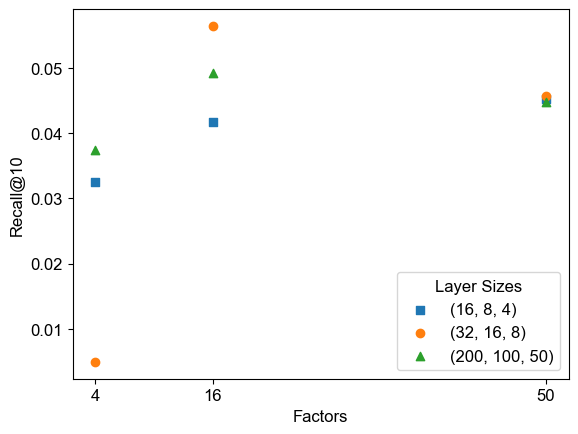

In [ ]:
# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Define Font Size
plt.rcParams.update({'font.size': 12})

# Create a dictionary to store the plotted points for each category
plotted_points = {}

# Create a scatterplot
fig, ax = plt.subplots()

# Define the shapes for different categories
shapes = ['s', 'o', '^']

# Iterate over each row in the DataFrame
for index, row in df_tuning.iterrows():
    # Get the layer sizes list for the current row
    layer_sizes = row['layer size']
    
    # Convert the layer sizes list to a tuple for dictionary key
    layer_sizes_tuple = tuple(layer_sizes)
    
    # Check if the current category is already in the dictionary
    if layer_sizes_tuple not in plotted_points:
        # Create a new list to store the points for the current category
        plotted_points[layer_sizes_tuple] = []
    
    # Append the points for the current category
    plotted_points[layer_sizes_tuple].append((row['factors'], row['recall@10']))

# Iterate over the plotted points for each category and plot them
for category, points in plotted_points.items():
    factors, recall = zip(*points)
    shape = shapes.pop(0)  # Get the next shape from the list
    ax.scatter(factors, recall, marker=shape, label=str(category))

# Set the labels for x and y axes
ax.set_xlabel('Factors')
ax.set_ylabel('Recall@10')

# Set the x-axis ticks to the desired values
ax.set_xticks([4, 16, 50])

# Add a legend with the label "Layer Sizes" above the points
legend = ax.legend(title='Layer Sizes', loc='lower right')
legend.get_title().set_fontsize('12')  # Set the font size of the legend title

# Show the scatterplot
plt.show()


Text(0, 0.5, 'Accuracy on Test Set')

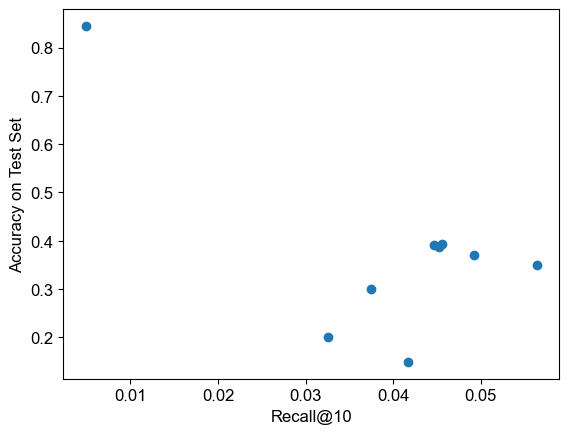

In [ ]:
#plt.figure(figsize=(7,5))
plt.scatter(df_tuning['recall@10'], df_tuning['accuracy'])
plt.xlabel('Recall@10')
plt.ylabel('Accuracy on Test Set')